# Predictive Modeling of Race Positions

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
import xgboost as xgb

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('use_inf_as_na', True)

## Import Data and Scrape Weather Data

In [77]:
# Import all the data
drivers_df = pd.read_csv("./f1db_csv/drivers.csv").drop(columns = "url")
lap_times_df = pd.read_csv("./f1db_csv/lap_times.csv")
results_df = pd.read_csv("./f1db_csv/results.csv")
constructors_df = pd.read_csv("./f1db_csv/constructors.csv")
races = pd.read_csv("./f1db_csv/races.csv")

In [26]:
weather = races.iloc[:,[0,1,2]]

# Scrape data for weather
info = []

for link in races.url:
    try:
        df = pd.read_html(link)[0]
        if 'Weather' in list(df.iloc[:,0]):
            n = list(df.iloc[:,0]).index('Weather')
            info.append(df.iloc[n,1])
        else:
            df = pd.read_html(link)[1]
            if 'Weather' in list(df.iloc[:,0]):
                n = list(df.iloc[:,0]).index('Weather')
                info.append(df.iloc[n,1])
            else:
                df = pd.read_html(link)[2]
                if 'Weather' in list(df.iloc[:,0]):
                    n = list(df.iloc[:,0]).index('Weather')
                    info.append(df.iloc[n,1])
                else:
                    df = pd.read_html(link)[3]
                    if 'Weather' in list(df.iloc[:,0]):
                        n = list(df.iloc[:,0]).index('Weather')
                        info.append(df.iloc[n,1])
                    else:
                        driver = webdriver.Chrome()
                        driver.get(link)

                        # click language button
                        button = driver.find_element_by_link_text('Italiano')
                        button.click()
                        
                        clima = driver.find_element_by_xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr[9]/td').text
                        info.append(clima) 
                                
    except:
        info.append('not found')

In [39]:
# Create a df just for weather and clean it up
weather['weather'] = info
weather["weather"].iloc[1021] = "Warm, Sunny"
weather["weather"].iloc[1022] = "Warm, Sunny"
weather["weather"].iloc[1023] = "Warm, Sunny"
weather_dict = {'weather_warm': ['soleggiato', 'clear', 'warm', 'hot', 'sunny', 'fine', 'mild', 'sereno'],
               'weather_cold': ['cold', 'fresh', 'chilly', 'cool'],
               'weather_dry': ['dry', 'asciutto'],
               'weather_wet': ['showers', 'wet', 'rain', 'pioggia', 'damp', 'thunderstorms', 'rainy'],
               'weather_cloudy': ['overcast', 'nuvoloso', 'clouds', 'cloudy', 'grey', 'coperto']}
weather_df = pd.DataFrame(columns = weather_dict.keys())

for col in weather_df:
    weather_df[col] = weather['weather'].map(lambda x: 1 if any(i in weather_dict[col] for i in x.lower().split()) else 0)

weather_info = pd.concat([weather, weather_df], axis = 1)
weather_info
weather_info.tail(10)

,raceId,year,round,weather,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
1021,1034,2020,4,"Warm, Sunny",1,0,0,0,0
1022,1035,2020,5,"Warm, Sunny",1,0,0,0,0
1023,1036,2020,6,"Warm, Sunny",1,0,0,0,0
1024,1037,2020,7,not found,0,0,0,0,0
1025,1038,2020,8,not found,0,0,0,0,0
1026,1039,2020,9,not found,0,0,0,0,0
1027,1040,2020,10,not found,0,0,0,0,0
1028,1041,2020,11,not found,0,0,0,0,0
1029,1042,2020,12,not found,0,0,0,0,0
1030,1043,2020,13,not found,0,0,0,0,0


In [40]:
# Write this to a csv to be used later
weather_info.to_csv("./f1db_csv/weather.csv")

## Merging with other info for a PM dataset

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

np.set_printoptions(precision=4)

In [78]:
races = pd.read_csv('./f1db_csv/races.csv')
results = pd.read_csv('./f1db_csv/results.csv')
qualifying = pd.read_csv('./f1db_csv/qualifying.csv')
driver_standings = pd.read_csv('./f1db_csv/driver_standings.csv')
constructor_standings = pd.read_csv('./f1db_csv/constructor_standings.csv')
constructors = pd.read_csv('./f1db_csv/constructors.csv')
weather = pd.read_csv('./f1db_csv/weather.csv')
drivers = pd.read_csv('./f1db_csv/drivers.csv')
driver_history = pd.read_csv('./f1db_csv/driver_history.csv')
lap_times = pd.read_csv('./f1db_csv/lap_times.csv')

In [43]:
driver_history.sort_values("raceId")

,Unnamed: 0,driverName,number,nationality,year,name,date,raceId,constructorName,position,minQualifyingTime,racePosition,fastestLapTime,wins,points,driverStanding
7418,7418,Jarno Trulli,NaN,Italian,2009,Australian Grand Prix,2009-03-29,1,Toyota,8,85.265,3.0,88.916,0,6.0,3
7410,7410,Nick Heidfeld,NaN,German,2009,Australian Grand Prix,2009-03-29,1,BMW Sauber,11,85.504,10.0,88.283,0,0.0,10
7416,7416,Sébastien Buemi,NaN,Swiss,2009,Australian Grand Prix,2009-03-29,1,Toro Rosso,16,86.503,7.0,89.230,0,2.0,7
7417,7417,Timo Glock,NaN,German,2009,Australian Grand Prix,2009-03-29,1,Toyota,6,85.281,4.0,88.416,0,5.0,4
7419,7419,Mark Webber,NaN,Australian,2009,Australian Grand Prix,2009-03-29,1,Red Bull,10,85.241,12.0,88.508,0,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7398,7398,Sebastian Vettel,5.0,German,2020,70th Anniversary Grand Prix,2020-08-09,1035,Ferrari,12,87.078,12.0,90.785,0,10.0,13
7399,7399,Charles Leclerc,16.0,Monegasque,2020,70th Anniversary Grand Prix,2020-08-09,1035,Ferrari,8,86.614,4.0,90.552,0,45.0,4
7400,7400,Kimi Räikkönen,7.0,Finnish,2020,70th Anniversary Grand Prix,2020-08-09,1035,Alfa Romeo,20,88.493,15.0,91.756,0,0.0,18
7402,7402,Max Verstappen,33.0,Dutch,2020,70th Anniversary Grand Prix,2020-08-09,1035,Red Bull,4,86.176,1.0,89.465,1,77.0,2


In [79]:
# Drop a few columns
# driver_standings.drop(['driver_points_after_race', 'driver_wins_after_race', 'driver_standings_pos_after_race'] ,axis = 1, inplace = True)
# constructor_standings.drop(['constructor_points_after_race', 'constructor_wins_after_race','constructor_standings_pos_after_race' ],axis = 1, inplace = True)

# Merge together to create final df for predictions
df1 = pd.merge(races, weather[["raceId", "weather_warm", "weather_cold", "weather_dry", "weather_wet", "weather_cloudy"]], on=['raceId'])
df2 = pd.merge(df1, results[["raceId", "driverId", "constructorId", "grid", "position", "points", "milliseconds", "laps", "fastestLapSpeed"]], on=['raceId'])
df2 = df2.rename({'position' : 'finishingPosition', 'points' : 'pointsGained'}, axis = 1)
df3 = pd.merge(df2, driver_standings[["raceId", "driverId", "points", "position", "wins"]], on=['raceId', 'driverId'])
df3 = df3.rename({'position' : 'driverStanding', 'points' : 'cumulativePoints', 'wins' : 'driver_wins'}, axis = 1)
df4 = pd.merge(df3, constructor_standings[["raceId", "constructorId", "points", "position", "wins"]], how='left', on=['raceId', 'constructorId']) #from 1958
df4 = df4.rename({'position' : 'constructorStanding', 'points' : 'constructorPoints', 'wins' : 'constructorWins', 'name' : 'raceName'}, axis = 1)
df5 = pd.merge(df4, constructors[["constructorId", "name"]], on = "constructorId")
df5 = df5.rename({'name' : 'constructorName'}, axis = 1)

# Match drivers in driver history table to their driver IDs
drivers["driverName"] = drivers["forename"].str.cat(drivers["surname"],sep = " ")
df6 = pd.merge(driver_history, drivers[["driverName", "driverId"]], on = "driverName")

final_df = pd.merge(df5, df6[["raceId", "driverId", "minQualifyingTime", "fastestLapTime"]], on=['raceId', 'driverId'])
final_df = final_df.drop(columns = ["round", "circuitId", "time", "url", "constructorId"])

# Rearrange the columns so identifying information is at the beginning
key = lambda x: (x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'finishingPosition')
final_df = final_df[sorted(final_df, key=key)]

In [80]:
# Get dummies for categorical variables
df_dum = pd.get_dummies(final_df, columns = ['constructorName'])
# Convert date to datetime
df_dum["date"] = pd.to_datetime(df_dum["date"])
df_dum = df_dum.sort_values("date", ascending = True)
df_dum

,raceId,date,year,raceName,driverId,finishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,pointsGained,milliseconds,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,minQualifyingTime,fastestLapTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Arrows,constructorName_BAR,constructorName_BMW Sauber,constructorName_Benetton,constructorName_Brawn,constructorName_Caterham,constructorName_Ferrari,constructorName_Footwork,constructorName_Force India,constructorName_Forti,constructorName_HRT,constructorName_Haas F1 Team,constructorName_Honda,constructorName_Jaguar,constructorName_Jordan,constructorName_Ligier,constructorName_Lotus,constructorName_Lotus F1,constructorName_MF1,constructorName_Manor Marussia,constructorName_Marussia,constructorName_McLaren,constructorName_Mercedes,constructorName_Minardi,constructorName_Prost,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Sauber,constructorName_Spyker,constructorName_Spyker MF1,constructorName_Stewart,constructorName_Super Aguri,constructorName_Toro Rosso,constructorName_Toyota,constructorName_Tyrrell,constructorName_Virgin,constructorName_Williams
5988,224,1996-03-10,1996,Australian Grand Prix,79,11,0,0,1,0,0,15,0.0,\N,55,\N,0.0,11,0,1.0,5.0,0.0,95.715,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4942,224,1996-03-10,1996,Australian Grand Prix,49,8,0,0,1,0,0,9,0.0,\N,57,\N,0.0,8,0,0.0,7.0,0.0,94.494,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3434,224,1996-03-10,1996,Australian Grand Prix,56,3,0,0,1,0,0,3,4.0,5632971,58,\N,4.0,3,0,4.0,2.0,0.0,92.889,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5987,224,1996-03-10,1996,Australian Grand Prix,63,6,0,0,1,0,0,10,1.0,\N,57,\N,1.0,6,0,1.0,5.0,0.0,94.832,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6001,224,1996-03-10,1996,Australian Grand Prix,44,7,0,0,1,0,0,11,0.0,\N,57,\N,0.0,7,0,0.0,6.0,0.0,95.330,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1035,2020-08-09,2020,70th Anniversary Grand Prix,839,8,1,0,0,0,0,14,4.0,4846766,52,234.144,16.0,10,0,36.0,6.0,0.0,87.011,90.575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
768,1035,2020-08-09,2020,70th Anniversary Grand Prix,817,14,1,0,0,0,0,5,0.0,\N,51,232.621,20.0,9,0,36.0,6.0,0.0,86.297,91.168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7440,1035,2020-08-09,2020,70th Anniversary Grand Prix,826,10,1,0,0,0,0,16,1.0,4851662,52,233.723,2.0,16,0,14.0,7.0,0.0,87.882,90.738,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7379,1035,2020-08-09,2020,70th Anniversary Grand Prix,825,\N,1,0,0,0,0,17,0.0,\N,43,230.944,1.0,17,0,1.0,9.0,0.0,88.236,91.830,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# Merge lap times data
total_lap_times = pd.merge(lap_times, races[["raceId", "year"]], on = "raceId")
total_lap_times = total_lap_times[["raceId", "driverId", "milliseconds"]]
total_lap_times = total_lap_times.groupby(['raceId', 'driverId']).sum()
total_lap_times["seconds"] = total_lap_times.milliseconds / 1000
total_lap_times

milliseconds   seconds
raceId driverId                        
1      1              5658698  5658.698
       2              5662869  5662.869
       3              5661506  5661.506
       4              5660663  5660.663
       6              1560978  1560.978
...                       ...       ...
1035   844            4811282  4811.282
       846            4847537  4847.537
       847            4813889  4813.889
       848            4821139  4821.139
       849            4814496  4814.496

[9058 rows x 2 columns]

## A very preliminary test run of a model??

In [13]:
# Merge in the seconds for each race
df_dum_merged = pd.merge(df_dum, total_lap_times, on = ["raceId", "driverId"])
df_dum_merged = df_dum_merged.drop(columns = ["milliseconds_x", "milliseconds_y"])
# Look only at 2019 data right now
df_2019 = df_dum_merged[df_dum_merged.year == 2019]

# Drop teams that didn't exist in 2019
for col in df_2019.columns:
    if 'constructorName' in col and df_2019[col].sum() < 1:
        df_2019.drop(col, axis = 1, inplace = True)

df_2019 = df_2019.sort_values(["date", "driverId"], ascending = True)

# Reformat the data so that it's taking info from the previous race
# Separate the data from the current race and the previous race
current_df = df_2019[["raceId", "date", "year", "raceName", "driverId", "seconds", "weather_warm", "weather_cold", 
                      "weather_dry", "weather_wet", "weather_cloudy", "grid", "minQualifyingTime", 
                      "constructorName_Alfa Romeo", "constructorName_Ferrari", "constructorName_Haas F1 Team",
                      "constructorName_McLaren", "constructorName_Mercedes", "constructorName_Racing Point",
                      "constructorName_Red Bull", "constructorName_Renault", "constructorName_Toro Rosso",
                      "constructorName_Williams"]]
past_df = df_2019[["raceId", "date", "year", "raceName", "driverId", "finishingPosition", "pointsGained", 
                   "laps", "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints", "constructorStanding",
                   "constructorWins", "fastestLapTime"]]
# Change raceId for the past races so that info from the previous race gets matched to the current race for preds
past_df["raceId"] = past_df["raceId"] + 1

# Merge the two together for predictions
full_df = pd.merge(current_df, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps",
                                        "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", 
                                        "constructorPoints", "constructorStanding", "constructorWins", "fastestLapTime"]],
                   on = ["raceId", "driverId"], how = "inner")
full_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Toro Rosso,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1011,2019-03-31,2019,Bahrain Grand Prix,1,5661.295,1,0,0,0,0,3,88.190,0,0,0,0,1,0,0,0,0,0,2,18.0,58,221.839,18.0,2,0,44.0,1.0,1.0,86.057
1,1011,2019-03-31,2019,Bahrain Grand Prix,8,5708.765,1,0,0,0,0,8,89.022,1,0,0,0,0,0,0,0,0,0,8,4.0,57,216.277,4.0,8,0,4.0,6.0,0.0,88.270
2,1011,2019-03-31,2019,Bahrain Grand Prix,9,5662.063,1,0,0,0,0,20,91.799,0,0,0,0,0,0,0,0,0,1,17,0.0,55,213.821,0.0,17,0,0.0,10.0,0.0,89.284
3,1011,2019-03-31,2019,Bahrain Grand Prix,20,5697.363,1,0,0,0,0,2,88.160,0,1,0,0,0,0,0,0,0,0,4,12.0,58,217.054,12.0,4,0,22.0,2.0,0.0,87.954
4,1011,2019-03-31,2019,Bahrain Grand Prix,154,1648.762,1,0,0,0,0,11,89.015,0,0,1,0,0,0,0,0,0,0,\N,0.0,29,215.807,0.0,18,0,8.0,4.0,0.0,88.462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1030,2019-12-01,2019,Abu Dhabi Grand Prix,842,5657.001,1,0,0,0,0,11,97.089,0,0,0,0,0,0,0,0,1,0,2,18.0,71,214.185,95.0,6,0,83.0,6.0,0.0,72.425
388,1030,2019-12-01,2019,Abu Dhabi Grand Prix,844,5689.150,1,0,0,0,0,3,95.219,0,1,0,0,0,0,0,0,0,0,18,0.0,65,217.190,249.0,4,2,479.0,2.0,3.0,71.423
389,1030,2019-12-01,2019,Abu Dhabi Grand Prix,846,5671.979,1,0,0,0,0,6,96.436,0,0,0,1,0,0,0,0,0,0,8,4.0,71,214.472,45.0,11,0,140.0,4.0,0.0,72.328
390,1030,2019-12-01,2019,Abu Dhabi Grand Prix,847,5743.499,1,0,0,0,0,18,98.717,0,0,0,0,0,0,0,0,0,1,12,0.0,71,210.331,0.0,20,0,1.0,10.0,0.0,73.752


In [67]:
current_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_AlphaTauri,constructorName_Williams
7103,1031,2020-07-05,2020,Austrian Grand Prix,1,5456.428,1,0,0,0,0,5,62.951,0,0,0,0,1,0,0,0,0,0
7098,1031,2020-07-05,2020,Austrian Grand Prix,8,3980.856,1,0,0,0,0,19,65.224,1,0,0,0,0,0,0,0,0,0
7096,1031,2020-07-05,2020,Austrian Grand Prix,20,5480.284,1,0,0,0,0,11,64.206,0,1,0,0,0,0,0,0,0,0
7090,1031,2020-07-05,2020,Austrian Grand Prix,154,3695.277,1,0,0,0,0,15,64.691,0,0,1,0,0,0,0,0,0,0
7084,1031,2020-07-05,2020,Austrian Grand Prix,815,5465.831,1,0,0,0,0,6,63.860,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7172,1035,2020-08-09,2020,70th Anniversary Grand Prix,844,4811.282,1,0,0,0,0,8,86.614,0,1,0,0,0,0,0,0,0,0
7175,1035,2020-08-09,2020,70th Anniversary Grand Prix,846,4847.537,1,0,0,0,0,10,86.778,0,0,0,1,0,0,0,0,0,0
7177,1035,2020-08-09,2020,70th Anniversary Grand Prix,847,4813.889,1,0,0,0,0,15,87.455,0,0,0,0,0,0,0,0,0,1
7166,1035,2020-08-09,2020,70th Anniversary Grand Prix,848,4821.139,1,0,0,0,0,9,86.642,0,0,0,0,0,0,1,0,0,0


In [14]:
# Delete rows where there are nans
full_df = full_df.replace({r"\N": None})
full_df = full_df.dropna()

# Predict only on Bahrain
bahrain_df = full_df[full_df.raceId == 1011]

x = bahrain_df.iloc[:, 6:]
y = bahrain_df.iloc[:, 5]

# Split into test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

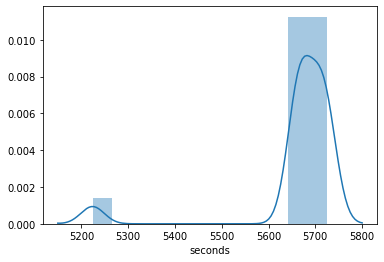

In [15]:
sns.distplot(y)

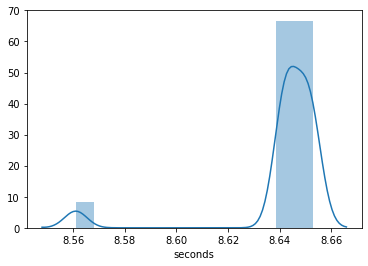

In [16]:
sns.distplot(np.log(y))

In [17]:
model = LinearRegression()
model.fit(x_train, y_train)

lr_preds = model.predict(x)
comparison_df = pd.DataFrame({"Actual" : y, "Predicted" : lr_preds})
comparison_df["Predicted"] = round(comparison_df.Predicted, 0)
comparison_df
test_df = pd.merge(comparison_df, bahrain_df[["year", "raceName", "driverId"]], left_index = True, right_index = True)
merged_df = pd.merge(test_df, drivers[["driverName", "driverId"]], on = "driverId")
merged_df.sort_values("Predicted")

AttributeError: module 'pandas' has no attribute 'merged'

In [ ]:
y_test

In [ ]:
x.info()

In [ ]:
x

In [ ]:
sns.distplot(lr_preds)

In [ ]:
mae = metrics.mean_absolute_error(y_test, lr_preds)
mse = metrics.mean_squared_error(y_test, lr_preds)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test, lr_preds)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

## 2020 stuff

**The Process:**

1. Create dummy table for constructors of that year
2. Get total lap time in terms of seconds and merge with dummy table
3. Drop milliseconds
4. Create 2 separate tables for current race info and past race info
5. Merge new table by adding 1 to race ID of previous race

In [160]:
# Merge in the seconds for each race
df_dum_merged = pd.merge(df_dum, total_lap_times, on = ["raceId", "driverId"])
df_dum_merged = df_dum_merged.drop(columns = ["milliseconds_x", "milliseconds_y"])

# Look only at 2020 data right now
df_2020 = df_dum_merged[df_dum_merged.year == 2020]

# Drop teams that didn't exist in 2020
for col in df_2020.columns:
    if 'constructorName' in col and df_2020[col].sum() < 1:
        df_2020.drop(col, axis = 1, inplace = True)

df_2020 = df_2020.sort_values(["date", "driverId"], ascending = True)

# Reformat the data so that it's taking info from the previous race
# Separate the data from the current race and the previous race
current_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "seconds", "weather_warm", "weather_cold", 
                      "weather_dry", "weather_wet", "weather_cloudy", "grid", "minQualifyingTime", 
                      "constructorName_Alfa Romeo", "constructorName_AlphaTauri", "constructorName_Ferrari", 
                      "constructorName_Haas F1 Team", "constructorName_McLaren", "constructorName_Mercedes", 
                      "constructorName_Racing Point", "constructorName_Red Bull", "constructorName_Renault", 
                      "constructorName_Williams"]]
past_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "finishingPosition", "pointsGained", 
                   "laps", "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints", "constructorStanding",
                   "constructorWins", "fastestLapTime"]]

# Change raceId for the past races so that info from the previous race gets matched to the current race for preds
past_df["raceId"] = past_df["raceId"] + 1

# Merge the two together for predictions
full_df = pd.merge(current_df, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps",
                                        "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", 
                                        "constructorPoints", "constructorStanding", "constructorWins", "fastestLapTime"]],
                   on = ["raceId", "driverId"], how = "inner")
full_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
1,1032,2020-07-12,2020,Styrian Grand Prix,8,5008.802,1,0,0,0,0,16,81.140,1,0,0,0,0,0,0,0,0,0,\N,0.0,53,225.185,0.0,14,0,2.0,7.0,0.0,69.031
2,1032,2020-07-12,2020,Styrian Grand Prix,20,101.037,1,0,0,0,0,10,79.545,0,0,1,0,0,0,0,0,0,0,10,1.0,71,226.524,1.0,10,0,19.0,3.0,0.0,68.623
3,1032,2020-07-12,2020,Styrian Grand Prix,154,5009.618,1,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,0,\N,0.0,49,221.347,0.0,16,0,0.0,10.0,0.0,70.228
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1035,2020-08-09,2020,70th Anniversary Grand Prix,844,4811.282,1,0,0,0,0,8,86.614,0,0,1,0,0,0,0,0,0,0,3,15.0,52,236.130,33.0,5,0,43.0,4.0,0.0,89.813
74,1035,2020-08-09,2020,70th Anniversary Grand Prix,846,4847.537,1,0,0,0,0,10,86.778,0,0,0,0,1,0,0,0,0,0,5,10.0,52,235.488,36.0,4,0,51.0,3.0,0.0,90.058
75,1035,2020-08-09,2020,70th Anniversary Grand Prix,847,4813.889,1,0,0,0,0,15,87.455,0,0,0,0,0,0,0,0,0,1,12,0.0,52,233.404,0.0,19,0,0.0,10.0,0.0,90.862
76,1035,2020-08-09,2020,70th Anniversary Grand Prix,848,4821.139,1,0,0,0,0,9,86.642,0,0,0,0,0,0,0,1,0,0,8,4.0,52,239.123,26.0,6,0,78.0,2.0,0.0,88.689


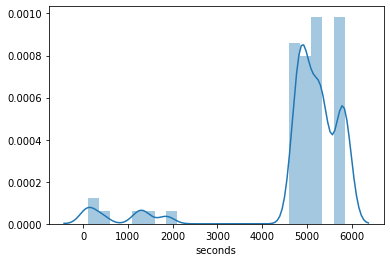

In [17]:
sns.distplot(full_df.seconds)

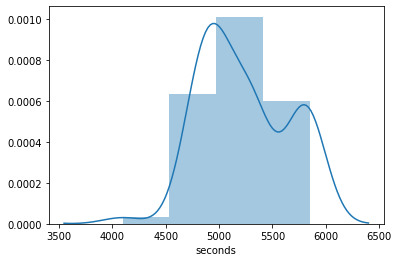

In [161]:
# Cut off the people who finished under 3000 seconds
shortened_df = full_df[full_df.seconds > 3000]
sns.distplot(shortened_df.seconds)

In [191]:
shortened_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
6,1032,2020-07-12,2020,Styrian Grand Prix,822,4984.402,1,0,0,0,0,4,78.657,0,0,0,0,0,1,0,0,0,0,1,25.0,71,229.758,25.0,1,1,37.0,1.0,1.0,67.657
8,1032,2020-07-12,2020,Styrian Grand Prix,826,5000.934,1,0,0,0,0,13,79.717,0,1,0,0,0,0,0,0,0,0,12,0.0,69,224.847,0.0,12,0,6.0,5.0,0.0,69.135
10,1032,2020-07-12,2020,Styrian Grand Prix,832,4989.726,1,0,0,0,0,3,78.590,0,0,0,0,1,0,0,0,0,0,5,10.0,71,228.687,10.0,5,0,26.0,2.0,0.0,67.974
13,1032,2020-07-12,2020,Styrian Grand Prix,841,5014.373,1,0,0,0,0,19,81.831,1,0,0,0,0,0,0,0,0,0,9,2.0,71,225.954,2.0,9,0,2.0,7.0,0.0,68.796
14,1032,2020-07-12,2020,Styrian Grand Prix,842,5029.170,1,0,0,0,0,7,78.744,0,1,0,0,0,0,0,0,0,0,7,6.0,71,225.205,6.0,7,0,6.0,5.0,0.0,69.025
16,1032,2020-07-12,2020,Styrian Grand Prix,846,5032.153,1,0,0,0,0,9,78.448,0,0,0,0,1,0,0,0,0,0,3,16.0,71,230.378,16.0,3,0,26.0,2.0,0.0,67.475
18,1032,2020-07-12,2020,Styrian Grand Prix,848,5015.083,1,0,0,0,0,6,79.014,0,0,0,0,0,0,0,1,0,0,13,0.0,67,227.156,0.0,13,0,0.0,9.0,0.0,68.432
19,1032,2020-07-12,2020,Styrian Grand Prix,849,4976.474,1,0,0,0,0,18,81.759,0,0,0,0,0,0,0,0,0,1,11,0.0,71,223.146,0.0,11,0,0.0,8.0,0.0,69.662


In [203]:
# Delete rows where there are nans
shortened_df = shortened_df.replace({r"\N": None})
shortened_df = shortened_df.dropna()

min_df = shortened_df.groupby("raceId", as_index = False)
min_lap_time = min_df.fastestLapTime.min()
temp1 = pd.merge(shortened_df, min_lap_time, on = "raceId")  
temp1["fastestLapRatio"] = temp1["fastestLapTime_x"] / temp1["fastestLapTime_y"]
temp1 = temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
min_quali_time = min_df.minQualifyingTime.min()
temp2 = pd.merge(temp1, min_quali_time, on = "raceId")
temp2["minQualiRatio"] = temp2["minQualifyingTime_x"] / temp2["minQualifyingTime_y"]
temp2 = temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
temp2

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapRatio,minQualiRatio
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,1.003512,1.000000
1,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,1.012301,1.048596
2,1032,2020-07-12,2020,Styrian Grand Prix,822,4984.402,1,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,1,25.0,71,229.758,25.0,1,1,37.0,1.0,1.0,1.002697,1.010691
3,1032,2020-07-12,2020,Styrian Grand Prix,826,5000.934,1,0,0,0,0,13,0,1,0,0,0,0,0,0,0,0,12,0.0,69,224.847,0.0,12,0,6.0,5.0,0.0,1.024602,1.024311
4,1032,2020-07-12,2020,Styrian Grand Prix,832,4989.726,1,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,5,10.0,71,228.687,10.0,5,0,26.0,2.0,0.0,1.007395,1.009830
5,1032,2020-07-12,2020,Styrian Grand Prix,841,5014.373,1,0,0,0,0,19,1,0,0,0,0,0,0,0,0,0,9,2.0,71,225.954,2.0,9,0,2.0,7.0,0.0,1.019578,1.051474
6,1032,2020-07-12,2020,Styrian Grand Prix,842,5029.170,1,0,0,0,0,7,0,1,0,0,0,0,0,0,0,0,7,6.0,71,225.205,6.0,7,0,6.0,5.0,0.0,1.022971,1.011809
7,1032,2020-07-12,2020,Styrian Grand Prix,846,5032.153,1,0,0,0,0,9,0,0,0,0,1,0,0,0,0,0,3,16.0,71,230.378,16.0,3,0,26.0,2.0,0.0,1.000000,1.008005
8,1032,2020-07-12,2020,Styrian Grand Prix,848,5015.083,1,0,0,0,0,6,0,0,0,0,0,0,0,1,0,0,13,0.0,67,227.156,0.0,13,0,0.0,9.0,0.0,1.014183,1.015278
9,1032,2020-07-12,2020,Styrian Grand Prix,849,4976.474,1,0,0,0,0,18,0,0,0,0,0,0,0,0,0,1,11,0.0,71,223.146,0.0,11,0,0.0,8.0,0.0,1.032412,1.050549


In [162]:
# Train on this above data
x = shortened_df.iloc[:, 6:]
x = x.drop(columns = "laps")
x["fastestLapSpeed"] = pd.to_numeric(x["fastestLapSpeed"])
x["finishingPosition"] = pd.to_numeric(x["finishingPosition"])
y = shortened_df.iloc[:, 5]

In [172]:
# Linear regression on this data to predict results for the 2020 Spanish Grand Prix
model = xgb.XGBRegressor(n_estimators = 300, max_depth = 9)
model.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [186]:
# Create df for Spanish Grand Prix
# Take final_df from all the merging done before
training_df1 = final_df[final_df.raceId == 1035]
# Get the minimum qualifying time from each driver for the Spanish Grand Prix
sp_quali_df = qualifying[qualifying.raceId == 1036]
sp_quali_df["minQualifyingTime"] = sp_quali_df[["q1", "q2", "q3"]].min(skipna = True, axis = 1)
sp_quali_df = sp_quali_df.drop(columns = ["q1", "q2", "q3"])
# Convert to seconds
for i in range(len(sp_quali_df['minQualifyingTime'])):
    if  sp_quali_df['minQualifyingTime'].iloc[i] != 0:
        sp_quali_df['minQualifyingTime'].iloc[i] = float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[1]) + (60 * float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[0]))
        i += 1
    else:
        sp_quali_df['minQualifyingTime'].iloc[i] = None
        i += 1
# Match the constructorId to the constructorName
sp_quali_df1 = pd.merge(sp_quali_df, constructors[["constructorId", "name"]], on = "constructorId")
sp_quali_df1 = sp_quali_df1.rename({'name' : 'constructorName', 'position': 'grid'}, axis = 1)
sp_quali_df1 = pd.get_dummies(sp_quali_df1, columns = ['constructorName'])
sp_quali_df2 = pd.merge(sp_quali_df1, weather_info, on = "raceId")

# Rearrange this df so it's in the same format 
sp_quali_df2 = sp_quali_df2[["raceId", "driverId", "weather_warm", "weather_cold", "weather_dry", "weather_wet",
                             "weather_cloudy", "grid", "minQualifyingTime", "constructorName_Alfa Romeo", 
                             "constructorName_AlphaTauri", "constructorName_Ferrari", "constructorName_Haas F1 Team",
                             "constructorName_McLaren", "constructorName_Mercedes", "constructorName_Racing Point",
                             "constructorName_Red Bull", "constructorName_Renault", "constructorName_Williams"]]
x_test1 = pd.merge(sp_quali_df2, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps", "fastestLapSpeed",
                                     "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints",
                                     "constructorStanding", "constructorWins", "fastestLapTime"]], on = ["raceId", "driverId"], how = "left")
x_test1 = x_test1.replace({r"\N": None})
# x_test1 = x_test1.dropna()
x_test = x_test1.iloc[:, 2:]
x_test["fastestLapSpeed"] = pd.to_numeric(x_test["fastestLapSpeed"])
x_test["finishingPosition"] = pd.to_numeric(x_test["finishingPosition"])
x_test = x_test.drop(columns = "laps")

In [187]:
x_test

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1,0,0,0,0,1,75.584,0,0,0,0,0,1,0,0,0,0,2.0,19.0,239.766,107.0,1.0,3.0,180.0,1.0,4.0,88.451
1,1,0,0,0,0,2,75.643,0,0,0,0,0,1,0,0,0,0,3.0,15.0,236.256,73.0,3.0,1.0,180.0,1.0,4.0,89.765
2,1,0,0,0,0,3,76.292,0,0,0,0,0,0,0,1,0,0,1.0,25.0,237.049,77.0,2.0,1.0,113.0,2.0,1.0,89.465
3,1,0,0,0,0,6,77.029,0,0,0,0,0,0,0,1,0,0,5.0,10.0,237.017,36.0,6.0,0.0,113.0,2.0,1.0,89.477
4,1,0,0,0,0,4,76.482,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,0,0,0,5,76.589,0,0,0,0,0,0,1,0,0,0,6.0,8.0,233.365,28.0,7.0,0.0,41.0,5.0,0.0,90.877
6,1,0,0,0,0,7,76.876,0,0,0,0,1,0,0,0,0,0,13.0,0.0,234.193,15.0,11.0,0.0,53.0,4.0,0.0,90.556
7,1,0,0,0,0,8,77.084,0,0,0,0,1,0,0,0,0,0,9.0,2.0,233.826,38.0,5.0,0.0,53.0,4.0,0.0,90.698
8,1,0,0,0,0,9,76.953,0,0,1,0,0,0,0,0,0,0,4.0,12.0,234.203,45.0,4.0,0.0,55.0,3.0,0.0,90.552
9,1,0,0,0,0,11,76.168,0,0,1,0,0,0,0,0,0,0,12.0,0.0,233.602,10.0,13.0,0.0,55.0,3.0,0.0,90.785


In [188]:
# Predict on x_test
sp_preds = model.predict(x_test)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
sp_preds_df
merged_sp_df = pd.merge(sp_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
full_sp_df["avg_pred_lap"] = full_sp_df.Predictions / full_sp_df.laps
full_sp_df.sort_values("avg_pred_lap")

,Predictions,raceId,driverId,laps,driverName,avg_pred_lap
0,4794.211914,1036,1,52.0,Lewis Hamilton,92.196383
2,4795.320801,1036,830,52.0,Max Verstappen,92.217708
1,4800.880371,1036,822,52.0,Valtteri Bottas,92.324623
5,4803.080078,1036,840,52.0,Lance Stroll,92.366925
3,4817.053711,1036,848,52.0,Alexander Albon,92.635648
11,4824.767090,1036,826,52.0,Daniil Kvyat,92.783982
7,4827.512207,1036,846,52.0,Lando Norris,92.836773
8,4835.403320,1036,844,52.0,Charles Leclerc,92.988525
6,4839.396973,1036,832,52.0,Carlos Sainz,93.065326
13,4841.556641,1036,839,52.0,Esteban Ocon,93.106858


In [177]:
sp_2020_predictions = full_sp_df[["driverName", "avg_pred_lap"]].sort_values("avg_pred_lap")
sp_2020_predictions.to_csv("./sp_2020_predictions.csv")